# Combination of fits of different models

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.hidden_markov_model import PoissonHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import concatenate_sessions, fix_discontinuities
from fitting_functions import cross_validate_armodel, compute_inputs

functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import best__kappa, best_lag_kappa, plot_grid_search

one = ONE(mode='remote')

## Parameters

In [2]:
bin_size = 0.1
bin_size = 0.017
# bin_size = 0.02

# Plotting params
multiplier = 1/bin_size
multiplier = 1

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

# data_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v4_5Jul2024/' + str(bin_size) + '/'

In [4]:
data_file = "preprocessed_data_v5_01-20-2025"

if data_file == "preprocessed_data_v4_170724":
    use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
                ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
    var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
    idx_init_list = [0, 1, 2, 3, 7]
    idx_end_list = [1, 2, 3, 7, 9]
    
    # Load preprocessed data
    prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/90_trials/' + str(bin_size) + '/'
    idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + data_file, "rb"))
    collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)
    
elif data_file == "preprocessed_data_v4_171224_alltrials":
    use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count']]
    var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count']
    idx_init_list = [0, 1, 2]
    idx_end_list = [1, 2, 3]
    
    # Load preprocessed data
    prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
    idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + data_file, "rb"))
    collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

elif data_file == "preprocessed_data_v5_01-20-2025":
    use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
       '1.0', '2.0', '4.0', '8.0', '16.0']]
    var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', '0.25', '0.5',
       '1.0', '2.0', '4.0', '8.0', '16.0']
    idx_init_list = [0, 1, 2, 3]
    idx_end_list = [1, 2, 3, 9]
    
    # Load preprocessed data
    prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
    filename = prepro_results_path + data_file
    idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(filename, "rb"))
    collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)


In [4]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
threshold = 0.05
sticky = False
num_states = 2

num_lags = 1  # First order ARHMM
# num_states = 3
kappa = 1

# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
if sticky == True:
    kappas = [1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]
else:
    kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]


## Fit concatenated sessions with params from best fit for all variable sets (models)

In [13]:
for s, var_interest in enumerate(var_interest_map):
        
    index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
    idx_init = idx_init_list[index_var]
    idx_end = idx_end_list[index_var]
    var_names = use_sets[index_var]
    
    data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/grid_search/'
    os.chdir(data_path)
    files = os.listdir()
    
    # Loop through animals
    for m, mouse_name in enumerate(np.unique(mouse_names)):
            # mouse_name = 'NYU-45'
            # Get mouse data
            design_matrix = collapsed_matrices[mouse_name][:,idx_init:idx_end]
            # Get results from grid search
            os.chdir(data_path)
            if sticky == True:
                filename = "best_sticky_results_" + var_names[0] + '_' + mouse_name
            else:
                filename = "best_results_" + var_names[0] + '_' + mouse_name
            
            if filename in files:
                all_lls, all_baseline_lls, all_init_params, all_fit_params, _, kappas, Lags = pickle.load(open(filename, "rb"))
        
                # Prepare data 
                num_timesteps = np.shape(design_matrix)[0]
                emission_dim = np.shape(design_matrix)[1]
                shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
                train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
                
                # Retrieve best fits
                if 'Lick count' in var_names:
                    best_kappa, mean_bits_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
                    index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                    use_fold = int(best_fold[index_kappa])
                    
                    " Fit model with best params"
            
                    best_params = all_fit_params[best_kappa]
                    
                    # Find parameters for best fold
                    initial_probs = best_params[0].probs[use_fold]
                    transition_matrix = best_params[1].transition_matrix[use_fold]
                    emission_rates = best_params[2].rates[use_fold]      
                    
                    # Initialize new hmm
                    test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=best_kappa)
                    best_fold_params, props = test_phmm.initialize(key=jr.PRNGKey(0), method=method,
                                                    initial_probs=initial_probs,
                                                    transition_matrix=transition_matrix,               
                                                    emission_rates=emission_rates)  # not sure if I need to include  
                    
                    # Get state estimates for validation data
                    most_likely_states = test_phmm.most_likely_states(best_fold_params, shortened_array)
                    
                    # Plot grid search
                    plt.plot(mean_bits_LL)
                    plt.xlabel('Kappa')
                    plt.xticks(np.arange(0, len(kappas), 1), kappas)
                    plt.title(mouse_name + ' ' + var_interest)
                    plt.show()
                else:
                    best_lag, best_kappa, mean_bits_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)
                    index_lag = np.where(np.array(Lags)==best_lag)[0][0]
                    index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                    use_fold = int(best_fold[index_lag, index_kappa])
                
                    " Fit model with best params"
                    # Compute inputs for required timelags
                    my_inputs = compute_inputs(shortened_array, best_lag, emission_dim)
                    train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
                    
                    best_params = all_fit_params[best_lag][best_kappa]
                    
                    # Find parameters for best fold
                    initial_probs = best_params[0].probs[use_fold]
                    transition_matrix = best_params[1].transition_matrix[use_fold]
                    emission_weights = best_params[2].weights[use_fold]
                    emission_biases = best_params[2].biases[use_fold]
                    emission_covariances = best_params[2].covs[use_fold]        
                    
                    # Initialize new hmm
                    new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=best_lag, transition_matrix_stickiness=best_kappa)
                    best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                                    initial_probs=initial_probs,
                                                    transition_matrix=transition_matrix,               
                                                    emission_weights=emission_weights,
                                                    emission_biases=emission_biases, 
                                                    emission_covariances=emission_covariances,
                                                    emissions=shortened_array)  # not sure if I need to include  
                    
                    # Get state estimates for validation data
                    most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)
                                
                    # Plot grid search
                    plot_grid_search(best_kappa, best_lag, mean_bits_LL, kappas, Lags, mouse_name, var_interest)
                
                to_save = most_likely_states, use_fold

                # Save most_likely_states
                if sticky == True:
                    states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states_states/most_likely_states/sticky'
                else:
                    states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states_states/most_likely_states'
                os.chdir(states_results_path)
                pickle.dump(to_save, open("most_likely_states" + var_names[0] + '_' + mouse_name , "wb"))   

TypeError: list indices must be integers or slices, not tuple

# Individual sessions

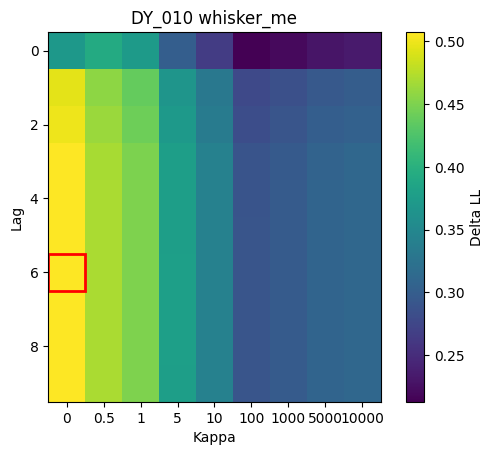

IndexError: list index out of range

In [7]:
for s, var_interest in enumerate(var_interest_map):

    index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
    idx_init = idx_init_list[index_var]
    idx_end = idx_end_list[index_var]
    var_names = use_sets[index_var]

    data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'
    os.chdir(data_path)
    files = os.listdir()

    for m, mat in enumerate(idxs):
        if len(mat) > 35:

            mouse_name = mat[37:]
            session = mat[0:36]

            fit_id = str(mouse_name+session)
            if sticky:
                filename = "best_sticky_results_" + var_interest + '_' + fit_id
            else:
                filename = "best_results_" + var_interest + '_' + fit_id

            if filename in files:

                # Get mouse data
                design_matrix = matrix_all[mouse_name][session][:,idx_init:idx_end]

                # Prepare data
                num_timesteps = np.shape(design_matrix)[0]
                emission_dim = np.shape(design_matrix)[1]
                shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
                train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

                # Retrieve best fits
                if 'Lick count' in var_names:
                    # Get results from grid search
                    os.chdir(data_path)
                    all_lls, all_baseline_lls, all_init_params, all_fit_params, _, kappas = pickle.load(open(filename, "rb"))

                    best_kappa, mean_bits_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
                    index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                    use_fold = int(best_fold[index_kappa])

                    " Fit model with best params"

                    best_params = all_fit_params[best_kappa]

                    # Find parameters for best fold
                    initial_probs = best_params[0].probs[use_fold]
                    transition_matrix = best_params[1].transition_matrix[use_fold]
                    emission_rates = best_params[2].rates[use_fold]

                    # Initialize new hmm
                    test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=best_kappa)
                    best_fold_params, props = test_phmm.initialize(key=jr.PRNGKey(0), method=method,
                                                    initial_probs=initial_probs,
                                                    transition_matrix=transition_matrix,
                                                    emission_rates=emission_rates)  # not sure if I need to include

                    # Get state estimates for validation data
                    most_likely_states = test_phmm.most_likely_states(best_fold_params, shortened_array)

                    # Plot grid search
                    plt.plot(mean_bits_LL)
                    plt.xlabel('Kappa')
                    plt.xticks(np.arange(0, len(kappas), 1), kappas)
                    plt.title(mouse_name + ' ' + var_interest)
                    plt.show()
                else:

                    # Get results from grid search
                    os.chdir(data_path)
                    all_lls, all_baseline_lls, all_init_params, all_fit_params, _, kappas, Lags = pickle.load(open(filename, "rb"))

                    best_lag, best_kappa, mean_bits_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)
                    index_lag = np.where(np.array(Lags)==best_lag)[0][0]
                    index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                    use_fold = int(best_fold[index_lag, index_kappa])

                    " Fit model with best params"
                    # Compute inputs for required timelags
                    my_inputs = compute_inputs(shortened_array, best_lag, emission_dim)
                    train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))

                    best_params = all_fit_params[best_lag][best_kappa]

                    # Find parameters for best fold
                    initial_probs = best_params[0].probs[use_fold]
                    transition_matrix = best_params[1].transition_matrix[use_fold]
                    emission_weights = best_params[2].weights[use_fold]
                    emission_biases = best_params[2].biases[use_fold]
                    emission_covariances = best_params[2].covs[use_fold]

                    # Initialize new hmm
                    new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=best_lag, transition_matrix_stickiness=best_kappa)
                    best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                                    initial_probs=initial_probs,
                                                    transition_matrix=transition_matrix,
                                                    emission_weights=emission_weights,
                                                    emission_biases=emission_biases,
                                                    emission_covariances=emission_covariances,
                                                    emissions=shortened_array)  # not sure if I need to include

                    # Get state estimates for validation data
                    most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

                    # Plot grid search
                    plot_grid_search(best_kappa, best_lag, mean_bits_LL, kappas, Lags, mouse_name, var_interest)

                to_save = most_likely_states, use_fold

                # Save most_likely_states
                if sticky == True:
                    states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/sticky'
                else:
                    states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states'
                os.chdir(states_results_path)
                pickle.dump(to_save, open("most_likely_states" + var_names[0] + '_' + fit_id , "wb"))